In [1]:
%reload_ext autoreload
%autoreload 2

import sys

import numpy as np
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append('..')
from axionmirror.map_utils import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## 1. Get ON/OFF temperature

In [13]:
#========== Map grid ==========
pixel_size = np.deg2rad(0.1)

ra_edges = np.deg2rad(np.linspace(0, 360, int(360/0.1)))
dec_edges = np.deg2rad(np.linspace(-11, 90, int(110/0.1)))
ra_s  = (ra_edges[:-1]  + ra_edges[1:] ) / 2
dec_s = (dec_edges[:-1] + dec_edges[1:]) / 2
dec_weight = np.cos(dec_s - np.deg2rad(49.3))
dec_weight /= np.mean(dec_weight)

ra_grid, dec_grid = np.meshgrid(ra_s, dec_s)
radec_flat = np.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
radec_shape = (len(dec_s), len(ra_s))

coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
l_grid = np.array(coord_grid.galactic.l.rad)
b_grid = np.array(coord_grid.galactic.b.rad)
#lb_flat = np.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)

freq = 400 # [MHz]
nu_haslam = 408 # [MHz]
beta = -2.55

#========== haslam ==========
haslam_ds_map_hp = hp.read_map('../data/gsr/haslam408_ds_Remazeilles2014.fits')
haslam_ds_map_hp *= (freq/nu_haslam) ** beta
haslam_ds_map = hp.pixelfunc.get_interp_val(
    haslam_ds_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
)

#========== LST ==========
def LST2RA(h=0, m=0, s=0):
    return 2*np.pi * (3600*h + 60*m + s) / (23*3600 + 56*60 + 4)

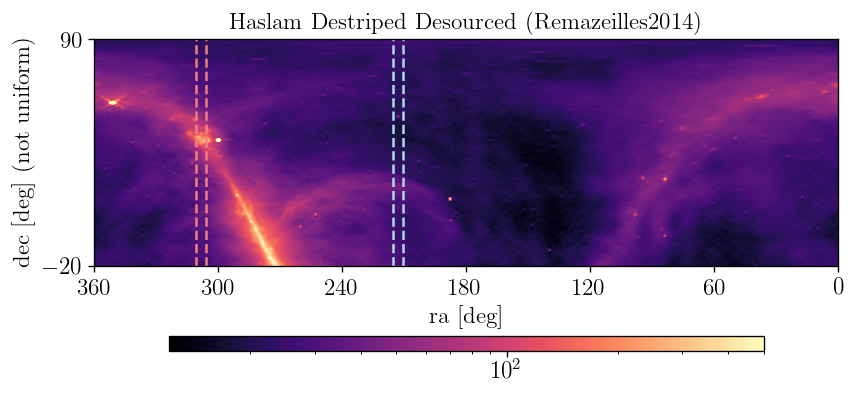

In [4]:
z = haslam_ds_map
extent = (360, 0, -20, 90)
vmax = 500
vmin = np.min(z)
norm = mpl.colors.LogNorm(vmin, vmax)

default_kwargs = dict(extent = extent, cmap = 'magma', norm = norm,)

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(jnp.flip(z), **default_kwargs)
ax.axvline(np.rad2deg(LST2RA(h=14, m=0 )), c='lightblue', ls='--')
ax.axvline(np.rad2deg(LST2RA(h=14, m=20)), c='lightblue', ls='--')
ax.axvline(np.rad2deg(LST2RA(h=20, m=20)), c='lightcoral', ls='--')
ax.axvline(np.rad2deg(LST2RA(h=20, m=40)), c='lightcoral', ls='--')
ax.set(aspect=1)
ax.set(title=r'Haslam Destriped Desourced (Remazeilles2014)',
       xlabel=r'ra [deg]', ylabel=r'dec [deg] (not uniform)')
ax.set(xticks=jnp.linspace(extent[0], extent[1], 7),
       yticks=jnp.linspace(extent[2], extent[3], 2))
fig.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal', aspect=40);

## 2. CHIME response

In [5]:
freqs = np.linspace(400, 800, 100) # [MHz]
CHIME_data = {}

for pol in ['x', 'y']:
    for level in ['low', 'high', 'base']:
        k = pol + level
        data = np.loadtxt(f'../data/telescopes/CHIME/{k}.txt', delimiter=',', unpack=True)
        CHIME_data[k] = np.interp(freqs, data[0], data[1])

In [14]:
i_ra_st = np.searchsorted(ra_s, LST2RA(h=14, m=0))
i_ra_ed = np.searchsorted(ra_s, LST2RA(h=14, m=20))
low_T = np.mean(haslam_ds_map[:,i_ra_st:i_ra_ed] * dec_weight[:,None])
print(low_T)
i_ra_st = np.searchsorted(ra_s, LST2RA(h=20, m=20))
i_ra_ed = np.searchsorted(ra_s, LST2RA(h=20, m=40))
high_T = np.mean(haslam_ds_map[:,i_ra_st:i_ra_ed] * dec_weight[:,None])
print(high_T)
high_Ts = high_T * (freqs / 408) ** (-2.5)
low_Ts  = low_T  * (freqs / 408) ** (-2.5)

24.347398056778353
51.90891562539533


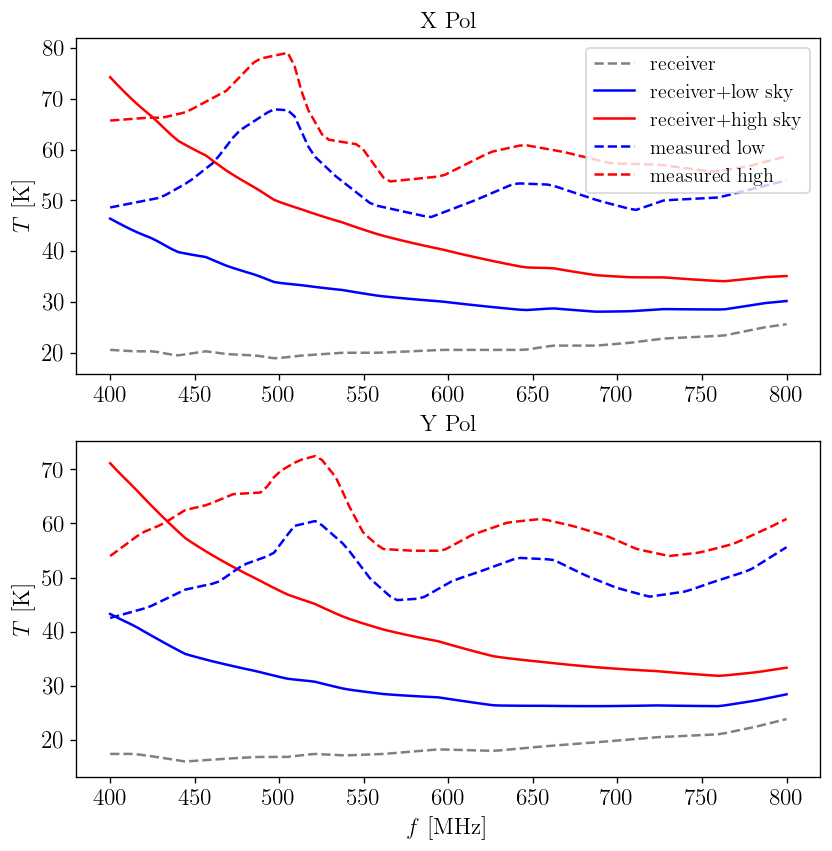

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(freqs, CHIME_data['xbase'], c='gray', ls='--', label='receiver')
axs[0].plot(freqs, CHIME_data['xbase'] + low_Ts, c='blue', label='receiver+low sky')
axs[0].plot(freqs, CHIME_data['xbase'] + high_Ts, c='red', label='receiver+high sky')
axs[0].plot(freqs, CHIME_data['xlow'], c='blue', ls='--', label='measured low')
axs[0].plot(freqs, CHIME_data['xhigh'], c='red', ls='--', label='measured high')
axs[0].set(title='X Pol', ylabel='$T$ [K]')
axs[0].legend()

axs[1].plot(freqs, CHIME_data['ybase'], c='gray', ls='--', label='receiver')
axs[1].plot(freqs, CHIME_data['ybase'] + low_Ts, c='blue', label='receiver+low sky')
axs[1].plot(freqs, CHIME_data['ybase'] + high_Ts, c='red', label='receiver+high sky')
axs[1].plot(freqs, CHIME_data['ylow'], c='blue', ls='--', label='measured low')
axs[1].plot(freqs, CHIME_data['yhigh'], c='red', ls='--', label='measured high')
axs[1].set(title='Y Pol', xlabel='$f$ [MHz]', ylabel='$T$ [K]');
#axs[1].legend()

In [15]:
(np.mean(CHIME_data['xlow'] - low_Ts) + np.mean(CHIME_data['ylow'] - low_Ts) ) / 2

40.58902111768111

In [14]:
np.mean(CHIME_data['xbase']), np.mean(CHIME_data['ybase'])

(21.189428671856753, 18.680713532320706)

In [15]:
(np.mean(CHIME_data['xbase']) + np.mean(CHIME_data['ybase'])) / 2

19.935071102088727

## A. Fit for $\eta$ and $T_\text{sys}$ (not in use)

We assume

$T_\text{response} = \eta\cdot T_\text{sky} + T_\text{sys}$.

Then

$\eta = \left(T_\text{response,high}-T_\text{response,low}\right) \big/ \left(T_\text{sky,high}-T_\text{sky,low}\right)$,

$T_\text{sys} = T_\text{response}-\eta\cdot T_\text{sky}$.

In [21]:
eta_arr = (CHIME_data['xhigh']-CHIME_data['xlow'])/(high_Ts-low_Ts)
T_sys_arr = CHIME_data['xlow'] - low_Ts * (eta_arr)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(freqs, eta_arr)
axs[0].set(ylim=(0, None))
axs[0].set(xlabel='$f$ [MHz]', ylabel='$\eta$')

axs[1].plot(freqs, T_sys_arr)
axs[1].set(xlabel='$f$ [MHz]', ylabel='$T_\mathrm{sys}$')
axs[1].set(ylim=(0, None))

In [ ]:
print(np.mean(eta_arr))
print(np.mean(np.clip(eta_arr, None, 1)))

In [ ]:
np.mean(T_sys_arr)